In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly_express as px
from importlib import reload

In [2]:
NOTEBOOK_DIR = os.getcwd()

### Basic Binary Classifier (SGD) for MNIST digits

In [3]:
from sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist["data"].values, mnist["target"].astype(np.uint8)

In [18]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

5

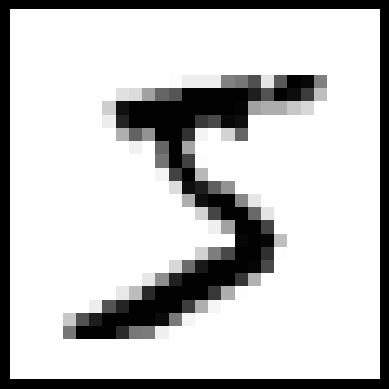

In [19]:
sample_digit = X[0]
plot_digit(sample_digit)
y[0]

In [48]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# # Can use this if data not properly shuffled and stratified like MNIST:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=6/7, random_state=0)

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([sample_digit])

array([ True])

### Cross-validation and Eval

In [60]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
# Baseline
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
# print(any(dummy_clf.predict(X_train)))

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [40]:
# Same effect as cross_val_score above but allows for more tweaks if needed.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    # print(train_index)
    # print(test_index)
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

In [52]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred); cm
# cm = confusion_matrix(y_train_5, y_train_pred, normalize="true"); cm

array([[53892,   687],
       [ 1891,  3530]])

In [71]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [75]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [73]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [76]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [78]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [80]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

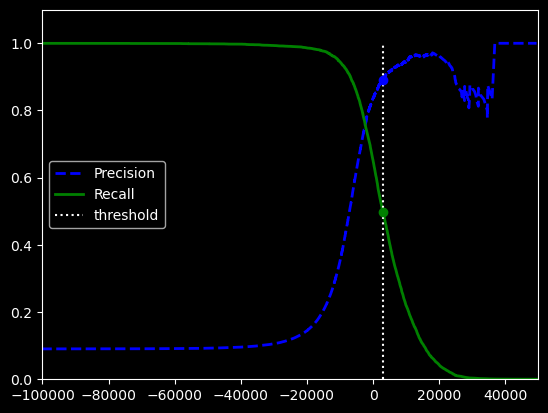

In [110]:
threshold = 3000
idx = (thresholds >= threshold).argmax() 

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "w", "dotted", label="threshold")
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-100000, 50000, 0, 1.1])
# plt.grid(color="grey")
plt.legend(loc="center left");

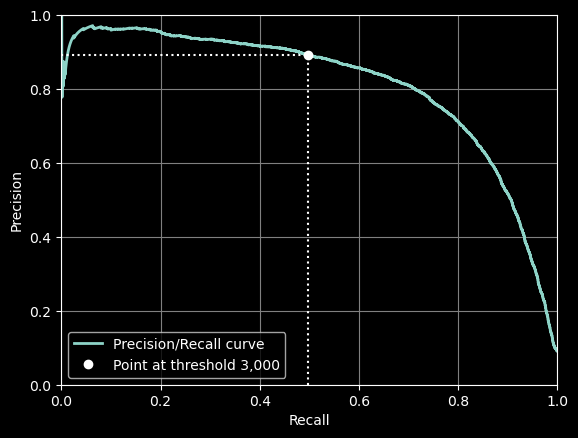

In [ ]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "w:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "w:")
plt.plot([recalls[idx]], [precisions[idx]], "wo",
         label="Point at threshold 3,000")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(color="grey")
plt.legend(loc="lower left");

In [115]:
idx_for_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_precision]
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [116]:
precision_score(y_train_5, y_train_pred_90)
# Successfully targeted 90% precision

0.9000345901072293

In [117]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90); recall_at_90_precision

0.4799852425751706

### ROC curve

In [119]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [120]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

(0.0, 1.0, 0.0, 1.0)

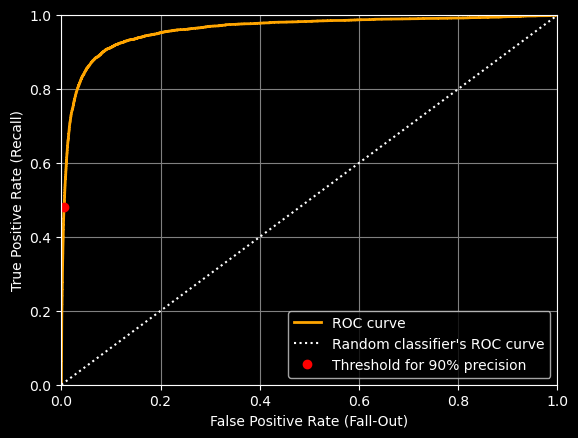

In [142]:
plt.plot(fpr, tpr, "orange", linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], "w:", label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ro", label="Threshold for 90% precision")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(color="grey")
plt.legend()
plt.axis([0, 1, 0, 1])

In [134]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Random Forest

In [143]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [144]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [145]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

Predicts that first image is positive (a 5) w/ 89% probability, and second image is not a 5 w/ 99% prob.

In [146]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

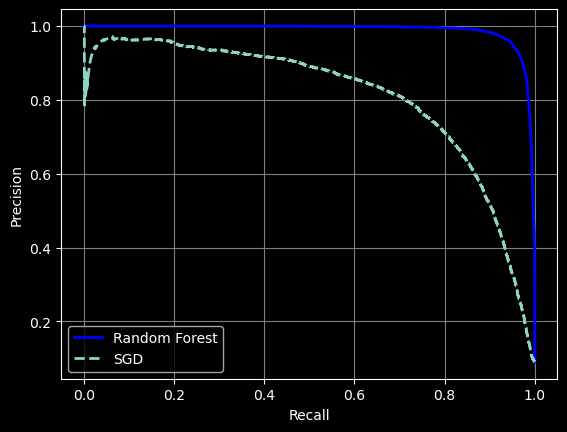

In [152]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.grid(color="grey")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend();

Random forest has much better performance based on area under precision/recall curve.

In [154]:
y_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5, y_pred_forest)

0.9274509803921569

In [155]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
precision_score(y_train_5, y_pred_forest)

0.9897468089558485

In [158]:
recall_score(y_train_5, y_pred_forest)

0.8725327430363402

### Multi-class classifiers and confusion matrix

In [168]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]);

In [165]:
svm_clf.predict([sample_digit])

array([5], dtype=uint8)

In [167]:
svm_clf.decision_function([sample_digit]).round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [169]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [171]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([sample_digit])

array([3], dtype=uint8)

In [172]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

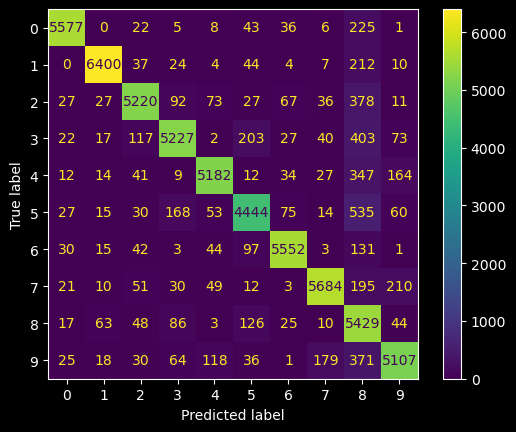

In [173]:
from sklearn.metrics import ConfusionMatrixDisplay
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

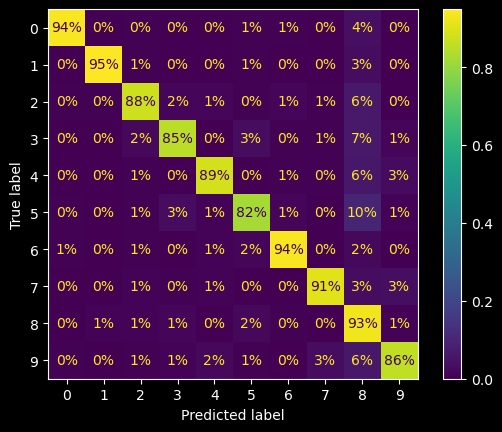

In [177]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%");

Make the misclassification patterns more apparent by applying 0 weight to correct predictions:

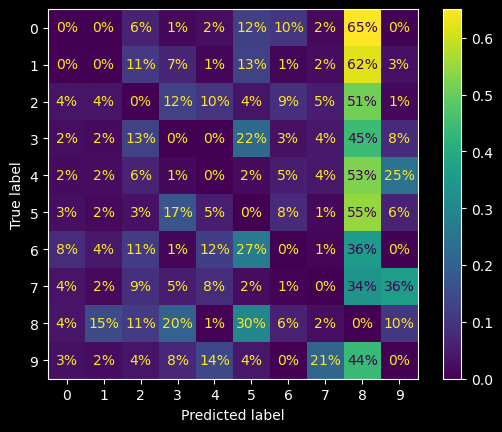

In [176]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight, 
                                        normalize="true", values_format=".0%");

### Multilabel classification

In [182]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train.astype("int8") % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel);

In [184]:
knn_clf.predict([sample_digit])

array([[False,  True]])

In [185]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048